Task:
- Training a Linear Regression model using scikit-learn library, to predict `median_house_value`, using "California Housing Prices" data from Kaggle.
- Using statsmodels to perform basic causal analysis to observe R-squared, Adj. R-squared, coefficients, and p-values.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#### Import Data

In [3]:
path = "./housing.csv"
data = pd.read_csv(path)

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

1. There's 20,640 data entries but "total_bedrooms" only has 20,433
2. "ocean_proximity" is str type object -> has to perform encoding for analysis

#### Cleaning data

In [7]:
null_data = data.isna().sum()
print("Missing values in each column\n", null_data, sep="", end="\n"*2)

null_data_percentage = (null_data / len(data)) * 100
print("Missing values % in each column\n", null_data_percentage, sep="")

# this method gives an overview of missing data, 
# if there's high % of missing values, consider imputation method

Missing values in each column
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Missing values % in each column
longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


In [8]:
# no. of data consist of missing values are not significant -> drop rows
data.dropna(inplace=True)
print(data.isnull().sum(), f"New data size = {data.shape}", sep="\n")

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
New data size = (20433, 10)


#### Data Visualization

In [9]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


According to the requirements of the task, the model aims to predict house prices for a general audience, excluding overly expensive locations & high income households.

##### (Before) Histogram & Boxplot 

c:\Users\PC\anaconda3\envs\py312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\PC\anaconda3\envs\py312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


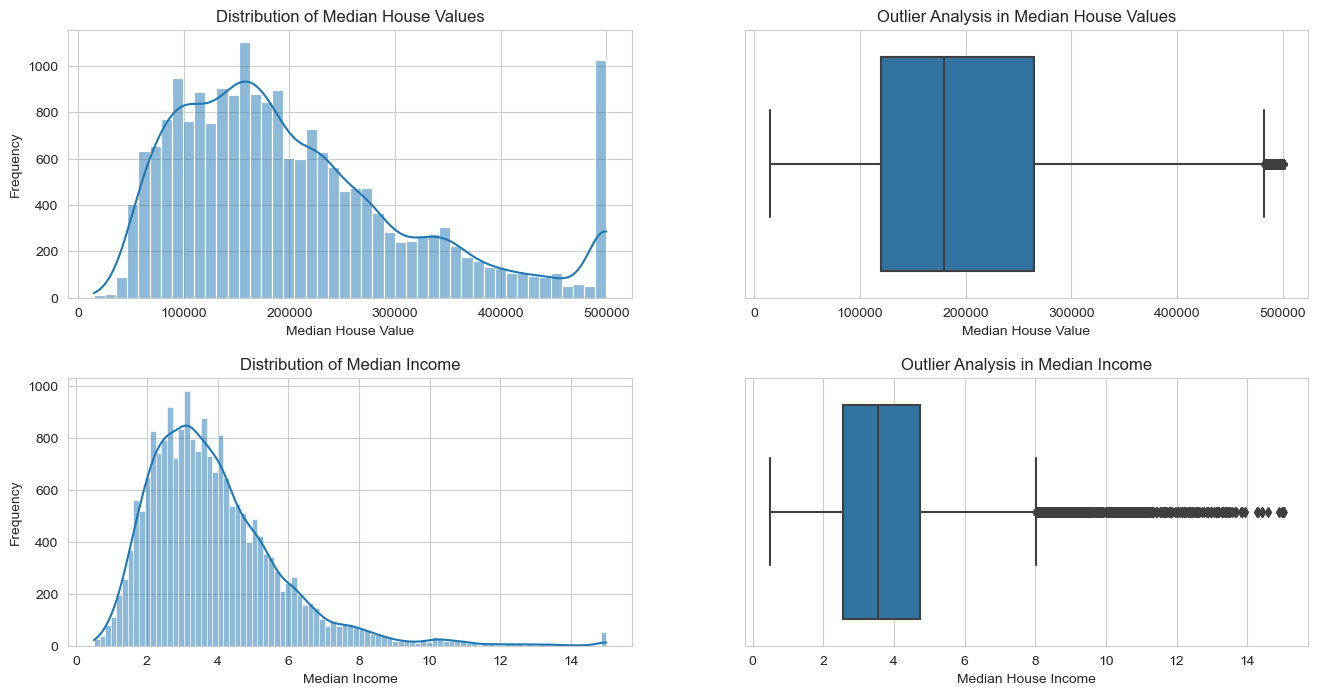

In [10]:
def outlier_plot(data):
    plt.figure(figsize=(16,8))
    sns.set_style(style="whitegrid")

    plt.subplot(2,2,1)
    sns.histplot(x=data["median_house_value"], kde=True)
    plt.xlabel("Median House Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Median House Values")

    plt.subplot(2,2,2)
    sns.boxplot(x=data["median_house_value"])
    plt.xlabel("Median House Value")
    plt.title("Outlier Analysis in Median House Values")

    plt.subplot(2,2,3)
    sns.histplot(x=data["median_income"], kde=True)
    plt.xlabel("Median Income")
    plt.ylabel("Frequency")
    plt.title("Distribution of Median Income")

    plt.subplot(2,2,4)
    sns.boxplot(x=data["median_income"])
    plt.xlabel("Median House Income")
    plt.title("Outlier Analysis in Median Income")

    plt.subplots_adjust(hspace=0.3)
    plt.show()

outlier_plot(data)

##### Removing Outliers with IQR

In [11]:
# Removing outliers from median house value
Q1 = data["median_house_value"].quantile(0.25)
Q3 = data["median_house_value"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
data_clean_1 = data[(data["median_house_value"] >= lower_bound) & (data["median_house_value"] <= upper_bound)]

print(f"Data shape without outliers = {data_clean_1.shape}")
print(f"Rows removed = {len(data) - len(data_clean_1)}")


Data shape without outliers = (19369, 10)
Rows removed = 1064


In [12]:
# Removing outliers from median income
Q1 = data["median_income"].quantile(0.25)
Q3 = data["median_income"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
data_clean_2 = data_clean_1[(data_clean_1["median_income"] >= lower_bound) & (data_clean_1["median_income"] <= upper_bound)]

print(f"Data shape without outliers = {data_clean_2.shape}")
print(f"Rows removed = {len(data_clean_1) - len(data_clean_2)}")


Data shape without outliers = (19149, 10)
Rows removed = 220


##### (After) Histogram & Boxplot 

c:\Users\PC\anaconda3\envs\py312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\PC\anaconda3\envs\py312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


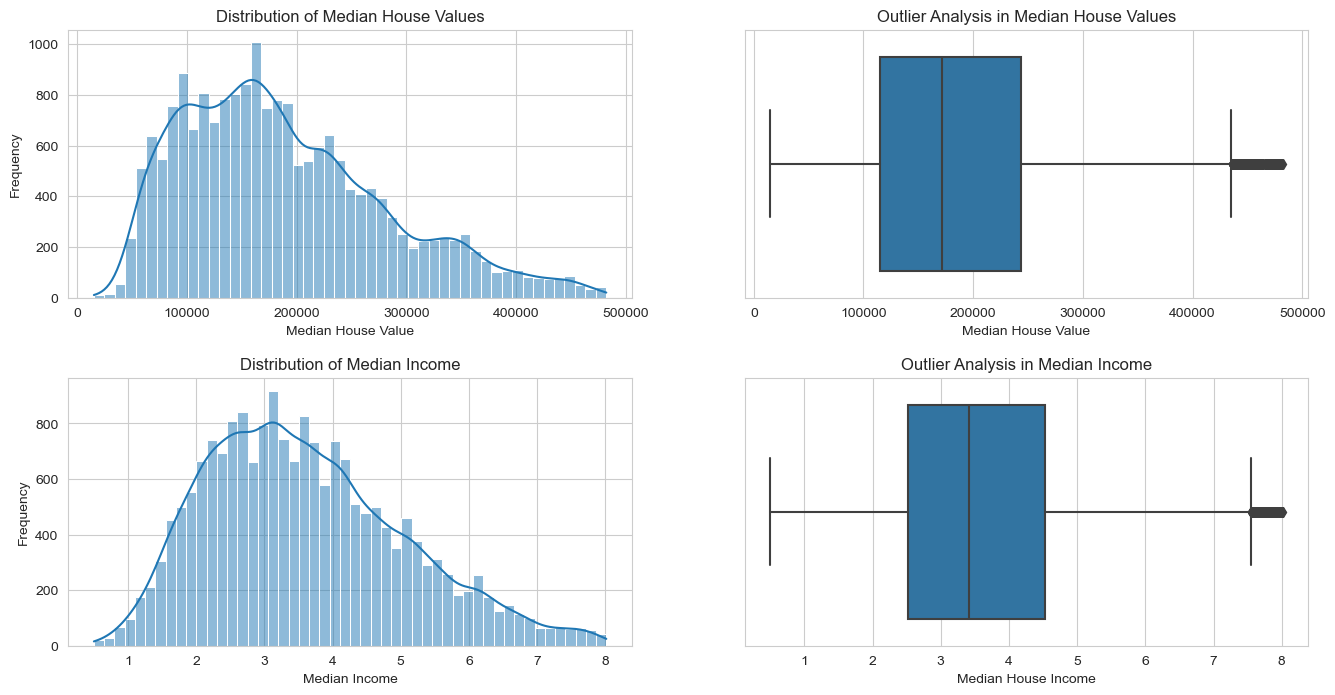

In [13]:
outlier_plot(data_clean_2)

In [14]:
data = data_clean_2

#### Correlation Heatmap

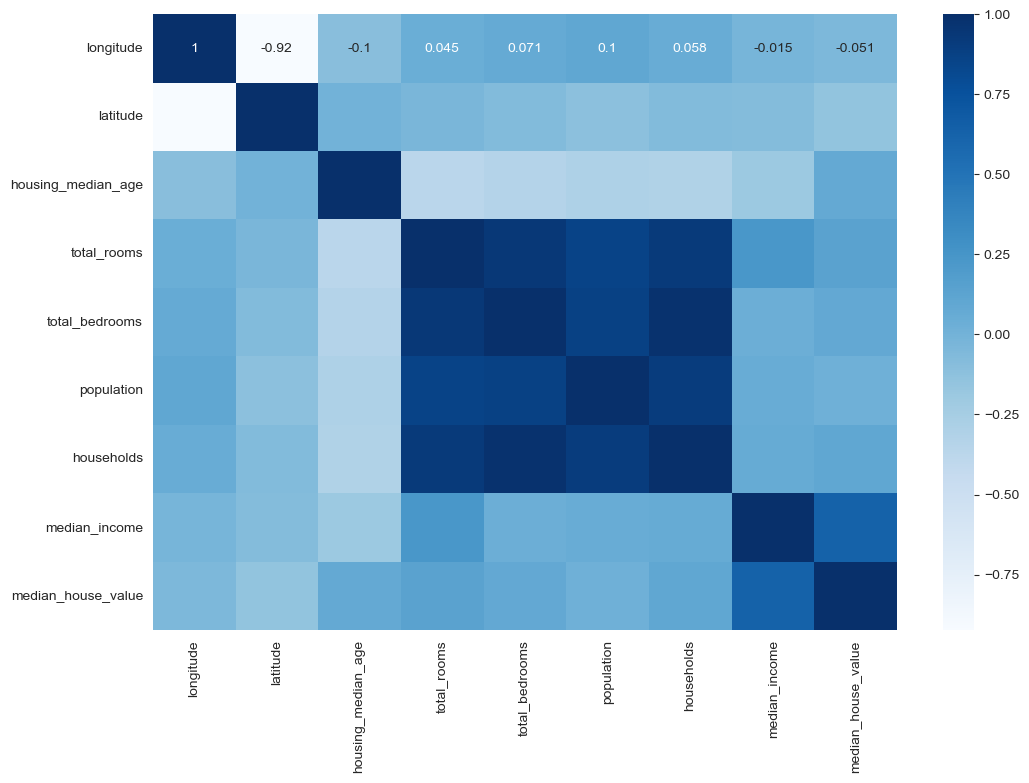

In [15]:
data_numerical = data.select_dtypes(include="number")

plt.figure(figsize=(12, 8))
sns.heatmap(data_numerical.corr(), xticklabels=True, yticklabels=True , annot=True, cmap="Blues")
plt.show()

In [16]:
# to prevent multicollinearity (multiple independent variable explaining the same thing, 
# model couldn't figure out effect of each variable),
# Dropping variable with highest correlation across all dependent variable 

data.drop(["households", "total_bedrooms"], inplace=True, axis=1)

C:\Users\PC\AppData\Local\Temp\ipykernel_9756\1515125759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["households", "total_bedrooms"], inplace=True, axis=1)


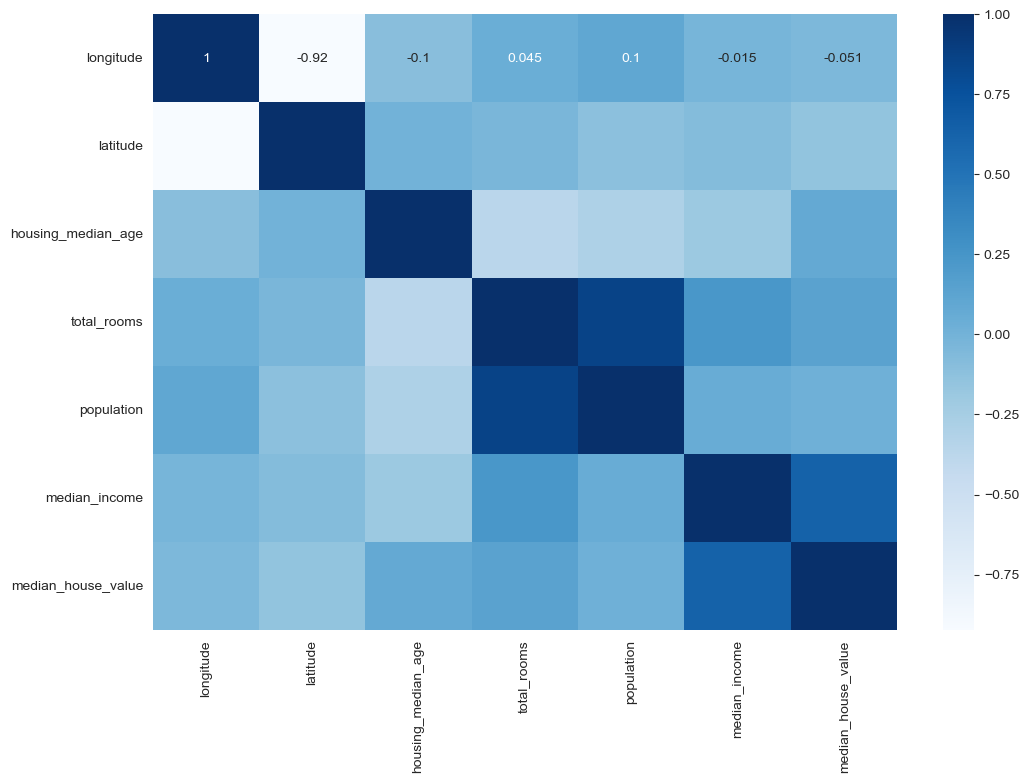

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.select_dtypes(include="number").corr(), xticklabels=True, yticklabels=True , annot=True, cmap="Blues")
plt.show()

#### Categorical String Data to Dummy Variable

In [18]:
ocean_proximity_dummies = pd.get_dummies(data["ocean_proximity"], prefix="ocean_proximity", dtype=int)
data = pd.concat([data.drop("ocean_proximity", axis=1), ocean_proximity_dummies], axis=1)
data.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
2,-122.24,37.85,52.0,1467.0,496.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,558.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,565.0,3.8462,342200.0,0,0,0,1,0
5,-122.25,37.85,52.0,919.0,413.0,4.0368,269700.0,0,0,0,1,0
6,-122.25,37.84,52.0,2535.0,1094.0,3.6591,299200.0,0,0,0,1,0


In [19]:
# avoid multicollinearity *independent variable only*
# for categorical variables with k categories, we create k-1 dummy variable (drop 1 variable)
# a dummy variable could be predicted by knowing other dummy's value, since sum of dummy variables = 1

data.drop("ocean_proximity_NEAR BAY", axis=1, inplace=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR OCEAN
2,-122.24,37.85,52.0,1467.0,496.0,7.2574,352100.0,0,0,0,0
3,-122.25,37.85,52.0,1274.0,558.0,5.6431,341300.0,0,0,0,0
4,-122.25,37.85,52.0,1627.0,565.0,3.8462,342200.0,0,0,0,0
5,-122.25,37.85,52.0,919.0,413.0,4.0368,269700.0,0,0,0,0
6,-122.25,37.84,52.0,2535.0,1094.0,3.6591,299200.0,0,0,0,0


#### Split data into Train/Test 

In [20]:
features = [col for col in data.columns.tolist() if col != "median_house_value"]
target = "median_house_value"

x = data[features]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=368)

print(f"Train data set: {x_train.shape[0]:,} samples")
print(f"Test data set: {x_test.shape[0]:,} samples")

Train data set: 15,319 samples
Test data set: 3,830 samples


#### Fitting OLS model

In [21]:
# adding a constant to the predictors because statsmodels' OLS doesn't include it by default
x_train_OLS = sm.add_constant(x_train)
x_train_OLS.head()

,const,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR OCEAN
16877,1.0,-122.40,37.60,52.0,1380.0,530.0,6.2210,0,0,0,1
14969,1.0,-117.01,32.75,34.0,2105.0,973.0,4.3088,1,0,0,0
9744,1.0,-121.68,36.72,12.0,19234.0,12153.0,3.2652,1,0,0,0
16508,1.0,-121.10,37.80,35.0,1853.0,958.0,3.3578,0,1,0,0
4848,1.0,-118.31,34.02,45.0,1423.0,822.0,2.4519,1,0,0,0


In [22]:
model_fitted = sm.OLS(y_train, x_train_OLS).fit()
print(model_fitted.summary())

# R-squared: higher indicates independent variables explain variability in dependent variables 
# p-value: low value (typically <0.05) suggests model is statistically significant (meaningful variable in this model, observations not due to random chance)
# coefficient: +1 of independent variable will cause a change in dependent variable by this much

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     2097.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        10:51:35   Log-Likelihood:            -1.9042e+05
No. Observations:               15319   AIC:                         3.809e+05
Df Residuals:                   15308   BIC:                         3.809e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### Train with sklearn

In [23]:
# standardize scale of dataset, so independent variables with large numbers doesn't have more influence on model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# do not apply standardization technique on dependent variable
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

##### Linear Regression

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Create and train model
model = LinearRegression()
model.fit(x_train_scaled, y_train)

# make predictions with test data
y_predictions = model.predict(x_test_scaled)

# calculate the MSE and RMSE
mse = mean_squared_error(y_test, y_predictions)
linreg_rmse = sqrt(mse)

print(f"RMSE on test set ${linreg_rmse:,.2f}")

RMSE on test set $60,622.32


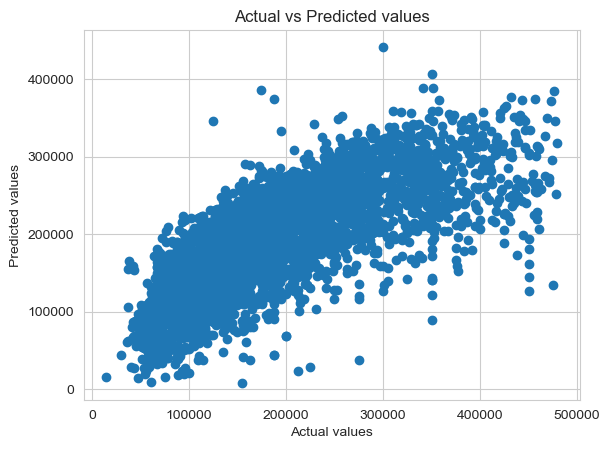

In [49]:
# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_predictions)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.show()

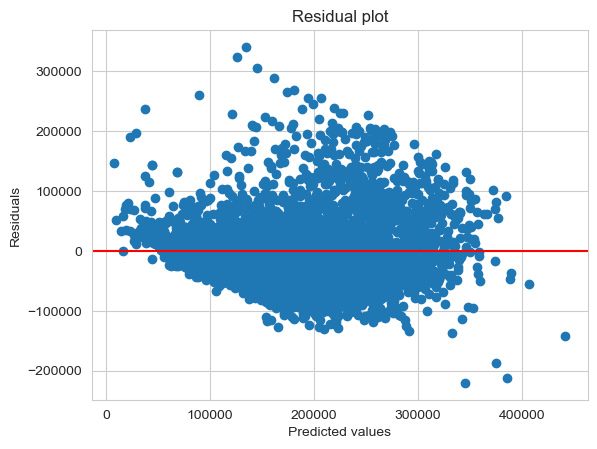

In [50]:
# Residual plot
residuals = y_test - y_predictions
plt.scatter(y_predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual plot')
plt.show()

Number of predictions: 3830


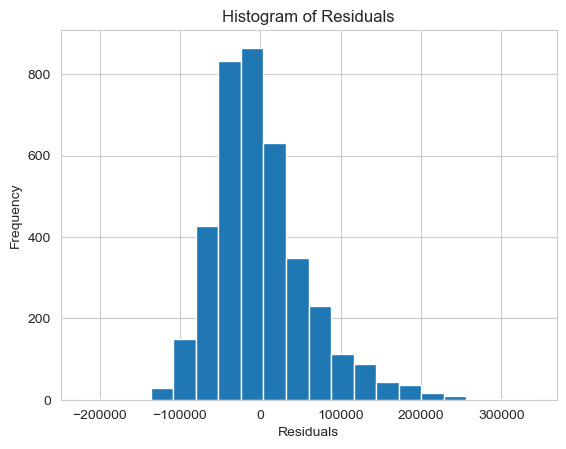

In [51]:
# Histogram of residuals
print(f"Number of predictions: {len(y_predictions)}")

plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

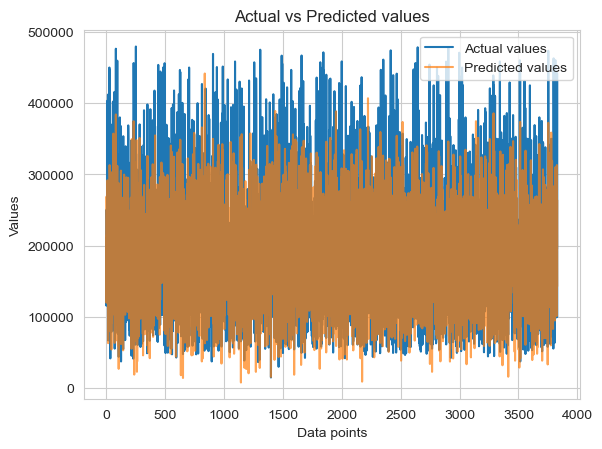

In [53]:
# Line plot of actual and predicted values
plt.plot(range(len(y_test)), y_test, label='Actual values')
plt.plot(range(len(y_test)), y_predictions, label='Predicted values', alpha=0.7)
plt.xlabel('Data points')
plt.ylabel('Values')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()